In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ==================================================
# 0. 의존성
# ==================================================
import torch, numpy as np, torch.nn as nn
import torch.autograd as autograd
from torch.nn.utils import spectral_norm
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset, random_split, ConcatDataset
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import os
from glob import glob
from PIL import Image

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IMG_SIZE     = 256                  # 이미지 크기
IN_CHANNELS  = 3                    # 입력 채널 (RGB)
ANOMALY_LABEL = 1
LATENT_DIM   = 256
BATCH, EPOCHS, TH_PCT = 16, 100, 95
LR_G, LR_D = 1e-4, 5e-5               # G 더 빠르게
lambda_gp, lambda_con, lambda_lat = 0, 20, 5
ALPHA = 0.9                      # score 가중치


In [3]:
# ==================================================
# 1. 데이터 셋업 (train / val / test)
# ==================================================
ROOT_DIR = '/content/drive/MyDrive/Data/MVTecAD/'

class MVTecADMulti(Dataset):
    def __init__(self, root_dir:str, phase:str='train'):
        assert phase in ('train', 'test')
        self.phase = phase
        self.paths = []
        cat_path = os.path.join(root_dir, 'bottle')

        if not os.path.isdir(cat_path):
            raise FileNotFoundError(f"지정된 경로에 'bottle' 폴더가 없습니다: {cat_path}")

        if phase == 'train':
            train_path = os.path.join(cat_path, 'train', 'good', '*.png')
            self.paths += [(p, 0) for p in glob(train_path)] # 정상: 0
        else:
            test_good_path = os.path.join(cat_path, 'test', 'good', '*.png')
            self.paths += [(p, 0) for p in glob(test_good_path)] # 정상: 0
            test_dir = os.path.join(cat_path, 'test')
            for defect in os.listdir(test_dir):
                if defect == 'good': continue
                defect_dir = os.path.join(test_dir, defect)
                if os.path.isdir(defect_dir):
                    defect_path = os.path.join(defect_dir, '*.png')
                    self.paths += [(p, 1) for p in glob(defect_path)] # 이상: 1

        self.tf = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3) # [0,1] -> [-1,1]
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path, label = self.paths[idx]
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.tf(img)
        return img_tensor, label, img_path


In [4]:
# --- 데이터셋 및 데이터로더 생성 ---
normal_ds = MVTecADMulti(ROOT_DIR, phase='train')
n_train = int(0.9 * len(normal_ds))
train_ds, val_ds = random_split(
    normal_ds, [n_train, len(normal_ds) - n_train],
    generator=torch.Generator().manual_seed(42)
)
test_ds = MVTecADMulti(ROOT_DIR, phase='test')

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("데이터셋 설정 완료!")
print(f"Train: {len(train_ds)}, Validation: {len(val_ds)}, Test: {len(test_ds)}")


데이터셋 설정 완료!
Train: 188, Validation: 21, Test: 83


In [5]:
# ==================================================
# 2. 네트워크 (U-Net 기반 Skip Connection 적용)
# ==================================================

# 인코더는 U-Net 구조를 위해 중간 출력을 반환하도록 수정
class UnetEncoder(nn.Module):
    def __init__(self, zdim=LATENT_DIM):
        super().__init__()
        self.e1 = nn.Sequential(nn.Conv2d(IN_CHANNELS, 32, 4, 2, 1), nn.LeakyReLU(0.2))
        self.e2 = nn.Sequential(nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2))
        self.e3 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2))
        self.e4 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2))
        self.e5 = nn.Sequential(nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2))
        self.e6 = nn.Sequential(nn.Conv2d(512, 1024, 4, 2, 1), nn.BatchNorm2d(1024), nn.LeakyReLU(0.2))
        self.fc = nn.Linear(1024 * 4 * 4, zdim)

    def forward(self, x):
        s1 = self.e1(x)       # (B, 32, 128, 128)
        s2 = self.e2(s1)     # (B, 64, 64, 64)
        s3 = self.e3(s2)     # (B, 128, 32, 32)
        s4 = self.e4(s3)     # (B, 256, 16, 16)
        s5 = self.e5(s4)     # (B, 512, 8, 8)
        s6 = self.e6(s5)     # (B, 1024, 4, 4)

        z = self.fc(s6.view(s6.size(0), -1))
        # Skip Connection을 위해 중간 출력(s1~s5)과 z를 함께 반환
        return z, [s1, s2, s3, s4, s5]

# 디코더는 Skip Connection을 입력으로 받아 사용하도록 수정
class UnetDecoder(nn.Module):
    def __init__(self, zdim=LATENT_DIM):
        super().__init__()
        self.fc = nn.Linear(zdim, 1024 * 4 * 4)

        # Skip Connection으로 들어오는 채널(1024+1024, 512+512 등)을 고려하여 in_channels 수정
        self.d1 = nn.Sequential(nn.ConvTranspose2d(1024, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.Dropout(0.5))
        self.d2 = nn.Sequential(nn.ConvTranspose2d(1024, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.Dropout(0.5))
        self.d3 = nn.Sequential(nn.ConvTranspose2d(512, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU())
        self.d4 = nn.Sequential(nn.ConvTranspose2d(256, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU())
        self.d5 = nn.Sequential(nn.ConvTranspose2d(128, 32, 4, 2, 1), nn.BatchNorm2d(32), nn.ReLU())
        self.d6 = nn.Sequential(nn.ConvTranspose2d(64, IN_CHANNELS, 4, 2, 1), nn.Tanh())

    def forward(self, z, skips):
        s1, s2, s3, s4, s5 = skips

        out = self.fc(z).view(-1, 1024, 4, 4)

        # torch.cat을 사용하여 Skip Connection 연결 (채널 차원으로 합침)
        out = self.d1(out)
        out = torch.cat([out, s5], dim=1) # (B, 512+512, 8, 8)

        out = self.d2(out)
        out = torch.cat([out, s4], dim=1) # (B, 256+256, 16, 16)

        out = self.d3(out)
        out = torch.cat([out, s3], dim=1) # (B, 128+128, 32, 32)

        out = self.d4(out)
        out = torch.cat([out, s2], dim=1) # (B, 64+64, 64, 64)

        out = self.d5(out)
        out = torch.cat([out, s1], dim=1) # (B, 32+32, 128, 128)

        out = self.d6(out)

        return out

# 기존 Encoder는 Generator의 두 번째 인코더(encoder2)로 재사용
class Encoder(nn.Module):
    def __init__(self, zdim=LATENT_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(IN_CHANNELS, 32, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, 4, 2, 1), nn.BatchNorm2d(1024), nn.LeakyReLU(0.2),
            nn.Flatten(),
        )
        self.fc = nn.Linear(1024 * 4 * 4, zdim)

    def forward(self, x):
        return self.fc(self.net(x))

# U-Net 기반의 새로운 Generator
class Generator(nn.Module):
    def __init__(self, zdim=LATENT_DIM):
        super().__init__()
        self.encoder1 = UnetEncoder(zdim)
        self.decoder = UnetDecoder(zdim)
        self.encoder2 = Encoder(zdim) # 두 번째 인코더는 Skip Connection이 필요 없으므로 기존 구조 사용

    def forward(self, x):
        z, skips = self.encoder1(x)
        x_hat = self.decoder(z, skips)
        z_hat = self.encoder2(x_hat)
        return x_hat, z, z_hat

# Discriminator는 변경할 필요가 없습니다.
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Conv2d(IN_CHANNELS, 64, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.net(x)

# 모델 생성
G, D = Generator().to(DEVICE), Discriminator().to(DEVICE)

In [6]:
# ==================================================
# 3. 학습 루프 (WGAN-GP + ℓ_con + ℓ_lat)
# ==================================================
opt_G = torch.optim.Adam(G.parameters(), LR_G, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), LR_D, betas=(0.5, 0.999))

def gradient_penalty(x_real, x_fake):
    alpha = torch.rand(x_real.size(0), 1, 1, 1, device=DEVICE)
    interpolated = (alpha * x_real + (1 - alpha) * x_fake).requires_grad_(True)
    d_interpolated = D(interpolated)
    grad = autograd.grad(
        outputs=d_interpolated, inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True, retain_graph=True
    )[0]
    grad_flat = grad.view(grad.size(0), -1)
    gp = ((grad_flat.norm(2, dim=1) - 1) ** 2).mean()
    return gp

for ep in range(1, EPOCHS + 1):
    G.train(); D.train()
    g_sum = d_sum = 0.
    n_critic = 5

    for i, (x, _, _) in enumerate(train_loader):
        x = x.to(DEVICE)
        # ----- 판별자(D) 학습 -----
        with torch.no_grad():
            x_fake, _, _ = G(x)

        d_real = D(x).mean()
        d_fake = D(x_fake).mean()
        gp = gradient_penalty(x.detach(), x_fake.detach())
        loss_D = d_fake - d_real + lambda_gp * gp

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        d_sum += loss_D.item() * x.size(0)

        # ----- 생성자(G) 학습 -----
        if (i + 1) % n_critic == 0:
            x_fake, z, z_hat = G(x)

            adv_loss = -D(x_fake).mean()
            con_loss = nn.functional.l1_loss(x, x_fake) # L1이 L2보다 시각적으로 나은 경우 많음
            lat_loss = nn.functional.mse_loss(z, z_hat)

            loss_G = adv_loss + lambda_con * con_loss + lambda_lat * lat_loss

            opt_G.zero_grad()
            loss_G.backward()
            opt_G.step()
            g_sum += loss_G.item() * x.size(0)

    print(f"[{ep:02d}/{EPOCHS}] | L_G: {g_sum/(len(train_ds)/n_critic):.4f} | L_D: {d_sum/len(train_ds):.4f}")


[01/100] | L_G: 26.9784 | L_D: -6.4057
[02/100] | L_G: 45.2934 | L_D: -93.8145
[03/100] | L_G: 62.5884 | L_D: -227.1947
[04/100] | L_G: 118.7053 | L_D: -388.8944
[05/100] | L_G: 49.8209 | L_D: -512.8562
[06/100] | L_G: 60.3503 | L_D: -622.8513
[07/100] | L_G: 8.7346 | L_D: -696.5382
[08/100] | L_G: -110.8086 | L_D: -762.8420
[09/100] | L_G: -216.8632 | L_D: -792.0767
[10/100] | L_G: -123.7820 | L_D: -791.9849
[11/100] | L_G: -312.9524 | L_D: -835.7501
[12/100] | L_G: -468.3366 | L_D: -801.9624
[13/100] | L_G: -506.1969 | L_D: -758.2990
[14/100] | L_G: -668.9451 | L_D: -754.3174
[15/100] | L_G: -613.3574 | L_D: -700.3578
[16/100] | L_G: -918.5746 | L_D: -634.1603
[17/100] | L_G: -769.4143 | L_D: -644.6464
[18/100] | L_G: -678.2628 | L_D: -555.7249
[19/100] | L_G: -725.8878 | L_D: -558.4557
[20/100] | L_G: -691.9789 | L_D: -511.5855
[21/100] | L_G: -856.4024 | L_D: -406.8755
[22/100] | L_G: -475.6223 | L_D: -316.3328
[23/100] | L_G: -267.1973 | L_D: -294.0171
[24/100] | L_G: -159.8390 | 

In [7]:
# ==================================================
# 4. 임계치 계산 (train+val 정상 90-percentile)
# ==================================================
def anomaly_score(x):
    G.eval()
    with torch.no_grad():
        x_hat, z, z_hat = G(x)
        con_loss = torch.mean(torch.abs(x - x_hat), dim=(1, 2, 3))
        lat_loss = torch.mean((z - z_hat)**2, dim=1)
    return ALPHA * con_loss + (1 - ALPHA) * lat_loss, x_hat

# --- val 데이터(정상)로 스코어 계산 ---
scores_val = []
with torch.no_grad():
    for x, _, _ in val_loader:
        x = x.to(DEVICE)
        sc, _ = anomaly_score(x)
        scores_val.extend(sc.cpu().numpy())

THRESH = np.percentile(scores_val, TH_PCT)
print(f"\n[Threshold] {TH_PCT}-percentile = {THRESH:.6f}")



[Threshold] 95-percentile = 0.125427


In [8]:
# ==================================================
# 5. 테스트 평가
# ==================================================
y_true, y_score = [], []
recon_store = []
G.eval()
with torch.no_grad():
    for x, y, _ in test_loader:
        x  = x.to(DEVICE)
        sc, xh = anomaly_score(x)
        y_score.extend(sc.cpu().numpy())
        y_true.extend(y.numpy()) # y는 이미 0 또는 1
        recon_store.append(((x.cpu(), xh.cpu(), y.cpu())))

auc = roc_auc_score(y_true, y_score)
ap = average_precision_score(y_true, y_score)
print(f"[Test] AUROC: {auc:.4f} | AUPRC: {ap:.4f}")

[Test] AUROC: 0.4976 | AUPRC: 0.8044


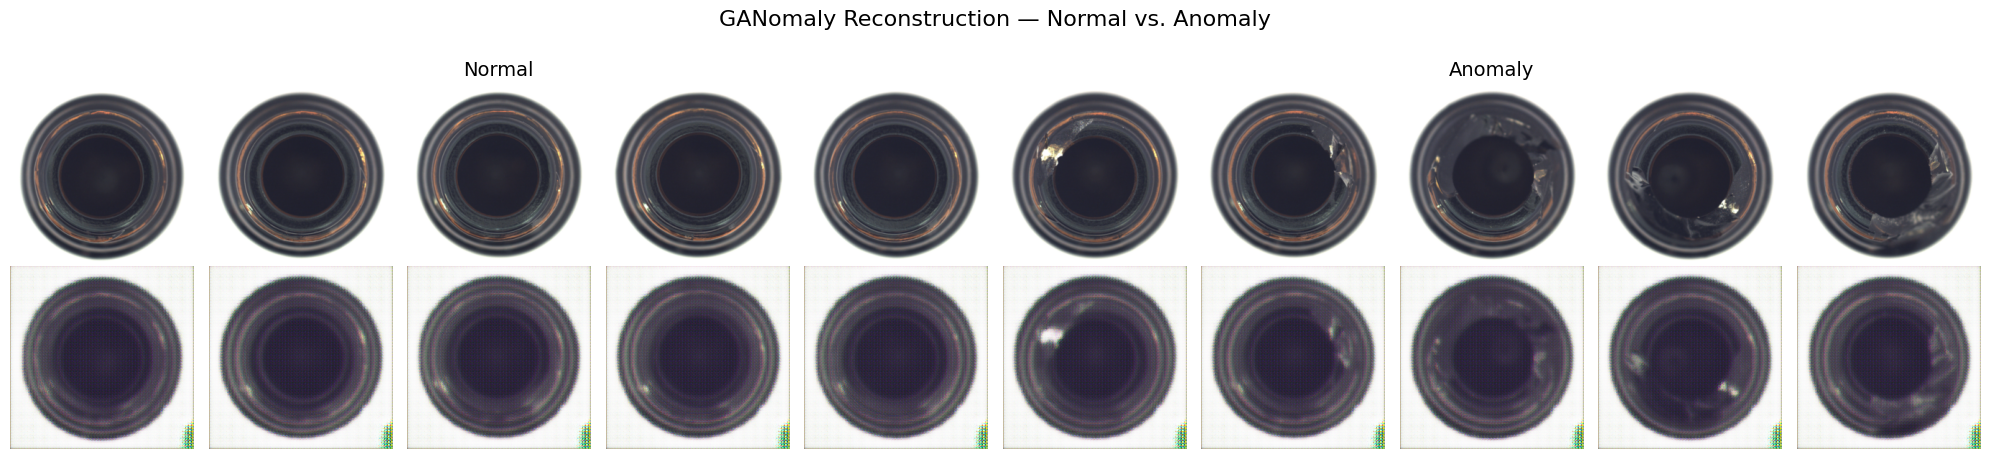

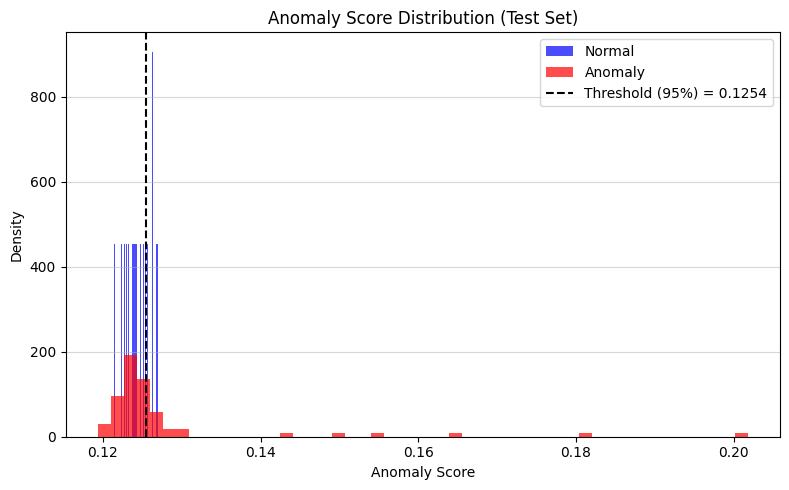

In [9]:
# ==================================================
# 6. 시각화
# ==================================================
# 6-1. 입력 ↔ 재구성 이미지 비교
norm_pairs, anom_pairs = [], []
for x_batch, xh_batch, y_batch in recon_store:
    for img, rec, label in zip(x_batch, xh_batch, y_batch):
        pair = (img.add(1).div(2), rec.add(1).div(2)) # [-1,1] -> [0,1]
        if label.item() == ANOMALY_LABEL and len(anom_pairs) < 5:
            anom_pairs.append(pair)
        elif label.item() == 0 and len(norm_pairs) < 5:
            norm_pairs.append(pair)
    if len(norm_pairs) >= 5 and len(anom_pairs) >= 5:
        break

fig, axes = plt.subplots(2, 10, figsize=(20, 4.5))
plt.suptitle("GANomaly Reconstruction — Normal vs. Anomaly", y=1.02, fontsize=16)

# Plot Normal Images
for col, (inp, rec) in enumerate(norm_pairs):
    axes[0, col].imshow(inp.permute(1, 2, 0))
    axes[0, col].axis("off")
    axes[1, col].imshow(rec.permute(1, 2, 0))
    axes[1, col].axis("off")

# Plot Anomaly Images
for col, (inp, rec) in enumerate(anom_pairs):
    i = col + 5
    axes[0, i].imshow(inp.permute(1, 2, 0))
    axes[0, i].axis("off")
    axes[1, i].imshow(rec.permute(1, 2, 0))
    axes[1, i].axis("off")

axes[0, 0].set_ylabel("Input", fontsize=12)
axes[1, 0].set_ylabel("Recon", fontsize=12)
axes[0, 2].set_title("Normal", fontsize=14)
axes[0, 7].set_title("Anomaly", fontsize=14)
plt.tight_layout()
plt.show()

# 6-2. 이상치 점수 분포 히스토그램
y_true = np.array(y_true)
y_score = np.array(y_score)
scores_norm = y_score[y_true == 0]
scores_anom = y_score[y_true == 1]

plt.figure(figsize=(8, 5))
plt.hist(scores_norm, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
plt.hist(scores_anom, bins=50, alpha=0.7, label='Anomaly', color='red', density=True)
plt.axvline(THRESH, linestyle="--", color="k", label=f"Threshold ({TH_PCT}%) = {THRESH:.4f}")
plt.title("Anomaly Score Distribution (Test Set)")
plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()